# Inverting gradient attack

We run the inverting gradient data poisoning attack by [Bouaziz et al.](https://arxiv.org/abs/2410.21453) We compare the effectiveness of machine unlearning as a defense, with a robust gradient aggregation rule.

We consider the same machine unlearning algorithms tested by [Pawelczyk et al.](https://arxiv.org/abs/2406.17216) and we use the $m$-KRUM aggregator introduced by [Blanchard et al.](https://arxiv.org/abs/1703.02757)

### Imports

In [1]:
from __future__ import annotations

from copy import deepcopy
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, Adam
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import MulticlassAccuracy
from IPython.display import clear_output

from image_classification.nn import Logs, test_epoch
from image_classification.accel import BEST_DEVICE

Using cpu device


## Base learning settings

### Model

For quick prototyping, also consider using [`ShuffleNetV2`](https://arxiv.org/abs/1807.11164v1), a 300M-parameter model that is much smaller than [`ResNet18`](https://arxiv.org/abs/1704.06904). Experiments can be made on both models or on only one of them.

In [2]:
from image_classification.models import ResNet18, ShuffleNetV2
from image_classification.datasets import cifar10_train_test, cifar100_train_test

### Dataset

We use CIFAR-10 by default.

In [3]:
# Set to 10 for CIFAR-10, 100 for CIFAR-100
num_classes = 10

# The images are already normalized by these datasets
if num_classes == 10:
    get_train_test = cifar10_train_test
elif num_classes == 100:
    get_train_test = cifar100_train_test
else:
    raise ValueError(f"Can't find CIFAR dataset with {num_classes} classes")
print(f"Loading CIFAR-{num_classes}")

training_data, test_data = get_train_test(root='data')
N_test = len(test_data)
N_val = len(training_data) // 10
N_aux = N_val
N = len(training_data) - N_val - N_aux
# This works since training data is already shuffled
training_data, val_data, aux_data = training_data.split([N, N_val, N_aux])

batch_size = 100
N, N_val, N_aux, N_test

Loading CIFAR-10


(40000, 5000, 5000, 10000)

In [4]:
train_loader = DataLoader(training_data, batch_size, drop_last=True)
test_loader = DataLoader(test_data, batch_size, drop_last=True)
val_loader = DataLoader(val_data, batch_size, drop_last=True)
aux_loader = DataLoader(aux_data, batch_size, drop_last=True)

### Hyperparameters

In [5]:
criterion = CrossEntropyLoss()

## Inverting gradient attack

In [6]:
from image_classification.gradient_attack import (
    GradientAttack,
    GradientEstimator, OmniscientGradientEstimator, ShadowGradientEstimator,
    SampleInit, SampleInitRandomNoise, LearningSettings, GradientInverter,
    Schedule, NeverUpdate
)
from inverting_gradient_attack import Pipeline, PipelineResults, Unlearning, Hyperparams
import federated as fed
#from federated import Aggregator, Mean, Krum
from inverting_gradient_attack import Aggregator, Mean, Krum # Avoids failing isinstance checks
from federated.utils import convert_bn_modules_to_gn

## Poisoning + Unlearning pipeline

In [7]:
def patch_network(network_factory: type[nn.Module]):
    """Patches a neural network factory to make it compatible to per-gradient backpropagation.
    
    This replaces a model's BatchNorm layers with GroupNorm.
    See `federated.utils` documentation for technical details.
    """
    def patch():
        return convert_bn_modules_to_gn(network_factory())
    
    return patch

### Evaluation

In [8]:
def compute_accuracy(model: nn.Module) -> float:
    """Compute the model accuracy on the test set."""
    metric = MulticlassAccuracy(num_classes)
    logger = test_epoch(
        model,
        test_loader,
        criterion,
        metric=metric,
    )
    return logger.metrics['MulticlassAccuracy'].compute().item()

### Pipeline

In [9]:
def run_pipeline(
        model_factory = ResNet18,
        aggregator = Mean(),
        inversion_method: GradientAttack | None = None,
        poison_factor: float = 0.2,
        unlearning_method: Unlearning | None = None,
        training_hparams: dict = {},
        unlearning_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run a training pipeline with default settings.

    The training may include poisoning with an inverting gradient attack,
    and perform unlearning after training.

    Parameters:
        model_factory (Module type): the neural network class.
        aggregator (Aggregator): a gradient aggregation method.
        inversion_method (GradientAttack, optional): the gradient inversion method.
        poison_factor (float, optional): the proportion of poisons in the training data.
        unlearning_method (Unlearning, optional): the unlearning algorithm.

        training_hparams (dict, optional): training hyperparameter overrides.
        unlearning_hparams (dict, optional): unlearning hyperparameter overrides.

        quicktesting (bool, defaults to False): whether to use a small model,
            a smaller subset of the training dataset and less training epochs
            for quicker testing iterations. Overrides hyperparameters when relevant.

    Returns:
        out (tuple[nn.Module, PipelineResults]): the trained and possibly unlearned model
            and the pipeline results.
    """
    poisoning = inversion_method is not None
    unlearning = unlearning_method is not None

    if poisoning:
        inverter = GradientInverter(
            method = inversion_method,
            estimator = ShadowGradientEstimator(aux_loader),
            steps = 5,
            sample_init = SampleInitRandomNoise(training_data),
        )
    
    settings = LearningSettings(
        criterion,
        aggregator = deepcopy(aggregator),
        num_clean = batch_size,
        num_byzantine = int(poison_factor / (1. - poison_factor) * batch_size),
    )

    hparams = Hyperparams(batch_size=batch_size, num_classes=num_classes)
    hparams = dataclasses.replace(hparams, **training_hparams)

    if quicktesting:
        model_factory = ShuffleNetV2
        mini_train_set, _ = random_split(training_data, [0.1, 0.9])
        train_loader_ = DataLoader(mini_train_set, batch_size)
        hparams = dataclasses.replace(hparams, epochs=1)
        if poisoning:
            inverter.steps = 1
    else:
        train_loader_ = train_loader

    pipeline = Pipeline(settings, train_loader_, val_loader, hparams)
    if unlearning:
        pipeline.unlearning_hparams[unlearning_method].update(unlearning_hparams)
    print(pipeline)

    model = patch_network(model_factory)().to(BEST_DEVICE)

    if poisoning and unlearning:
        unlearner, results = pipeline.poison_and_unlearn(model, inverter, unlearning_method)
        model = unlearner
    elif poisoning:
        poisoned, results = pipeline.poison(model, inverter)
        model = poisoned
    else:
        assert not unlearning, "Cannot unlearn when there is no poisoning"
        trained, results = pipeline.train(model)
        model = trained 
    
    return model, results

### Normal training

In [10]:
def train(
        model_factory = ResNet18,
        aggregator = Mean(),
        training_hparams: dict = {},
        quicktesting: bool = False,
) -> tuple[nn.Module, PipelineResults]:
    """Train the model normally.
    
    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        model_factory,
        aggregator=aggregator,
        poison_factor=0.0,
        training_hparams=training_hparams,
        quicktesting=quicktesting,
    )

### Training with data poisoning

This inverting gradient data poisoning attack can be defended by changing the aggregator to KRUM.

In [11]:
def poison(
        model_factory = ResNet18,
        aggregator = Mean(),
        inversion_method = GradientAttack.ASCENT,
        poison_factor: float = 0.2,
        training_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run the poisoning pipeline with default settings.

    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        model_factory,
        aggregator=aggregator,
        inversion_method=inversion_method,
        poison_factor=poison_factor,
        training_hparams=training_hparams,
        quicktesting=quicktesting,
    )

### Poisoning and then Unlearning

Machine unlearning is used against a gradient inversion data poisoning attack.

In [12]:
def poison_and_unlearn(
        model_factory = ResNet18,
        aggregator = Mean(),
        inversion_method = GradientAttack.ASCENT,
        poison_factor: float = 0.2,
        unlearning_method = Unlearning.NEG_GRAD_PLUS,
        training_hparams: dict = {},
        unlearning_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run the poison-and-unlearn pipeline with default settings.

    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        model_factory,
        aggregator=aggregator,
        inversion_method=inversion_method,
        poison_factor=poison_factor,
        unlearning_method=unlearning_method,
        training_hparams=training_hparams,
        unlearning_hparams=unlearning_hparams,
        quicktesting=quicktesting,
    )

## Experiments

### Assessing $m$-Krum's utility

We study the effect of using a robust aggregator on the model's test accuracy.

In [13]:
def assess_krum(
        model_factory: type[nn.Module],
        training_hparams = dict(epochs=1),
        n_points: int = 11,
    ) -> tuple[float, pd.DataFrame]:

    def baseline() -> float:
        model, _ = train(
            model_factory,
            aggregator = Mean(),
            training_hparams = training_hparams,
            quicktesting=False,
        )
        return compute_accuracy(model)
    
    def eval_krum_with_poison_factor(tol: float) -> float:
        model, _ = train(
            model_factory,
            aggregator = Krum.with_learning_settings(batch_size, tol),
            training_hparams = training_hparams,
            quicktesting=False,
        )
        clear_output(wait=True)
        return compute_accuracy(model)
        
    base_acc = baseline()

    x_f = np.linspace(0.0, 0.4, n_points)
    y_accuracy = np.vectorize(eval_krum_with_poison_factor)(x_f)

    df = pd.DataFrame({'f': x_f, 'accuracy': y_accuracy})
    return base_acc, df

In [14]:
base_acc, x_f_y_acc = assess_krum(ShuffleNetV2)

Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

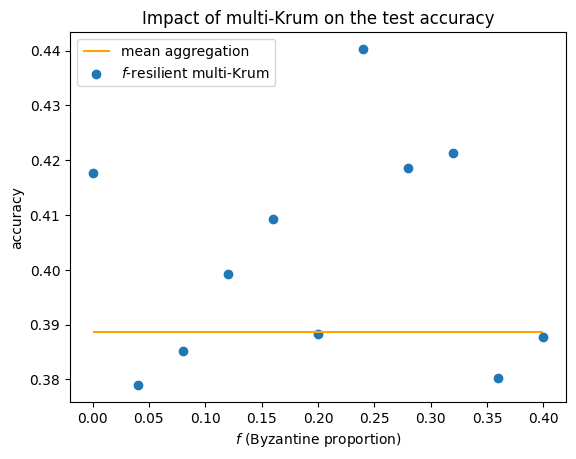

In [15]:
def display_krum_assessment(base_acc: float, x_f_y_acc: pd.DataFrame):
    # TODO: error bars + statistical test
    x_f = x_f_y_acc['f']
    y_accuracy = x_f_y_acc['accuracy']
    plt.hlines(base_acc, min(x_f), max(x_f), label="mean aggregation", colors='orange')

    plt.scatter(x_f, y_accuracy, label=r"$f$-resilient multi-Krum")
    plt.xlabel(r"$f$ (Byzantine proportion)")
    plt.ylabel(r"accuracy")
    plt.legend(loc="upper left")
    plt.title(r"Impact of multi-Krum on the test accuracy")
    plt.show()

display_krum_assessment(base_acc, x_f_y_acc)

In [16]:
print(f"Base accuracy (mean): {base_acc:.3}")
print(f"Krum accuracy:")
x_f_y_acc

Base accuracy (mean): 0.389
Krum accuracy:


,f,accuracy
0,0.00,0.4177
1,0.04,0.3790
2,0.08,0.3852
3,0.12,0.3992
4,0.16,0.4092
5,0.20,0.3883
6,0.24,0.4403
7,0.28,0.4186
8,0.32,0.4213
9,0.36,0.3802


When there is no poisoning, Krum incurs a minimal accuracy decrease (~3%) even in the most pessimistic learning settings. Since the accuracy also increases, we can tell with high statistical confidence that Krum does not decrease accuracy by a significant amount.

### Poison selection rate

We test GA, OG and LIE against $m$-Krum to compute the poison selection rate.

In [13]:
def eval_krum_selection_rate(
        model_factory: type[nn.Module],
        alpha: float,
        tol: float,
        method: GradientAttack,
        quicktesting: bool = True,
    ) -> np.ndarray:
    """Compute Krum poison selection rate."""
    num_clean = batch_size
    num_byzantine = int(alpha / (1. - alpha) * num_clean)
    _, poison_results = poison(
        model_factory,
        aggregator = Krum.with_learning_settings(num_clean, tol),
        inversion_method = method,
        poison_factor = alpha,
        training_hparams = dict(epochs=1),
        quicktesting=quicktesting,
    )
    clear_output()
    num_selected_poisons = poison_results.train_logs.train_metrics['num_selected_poisons']
    return (num_selected_poisons / num_byzantine).numpy(force=True)

def compute_selection_rate_table(
        model_factory: type[nn.Module],
        quicktesting: bool = True,
    ) -> pd.DataFrame:
    """Compute a poison selection rate table per model, poison factor, Krum tolerance."""
    poison_factor = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4])
    tolerance = np.array([0.1]) #np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4])
    atk_method = [
        GradientAttack.ASCENT,
        GradientAttack.ORTHOGONAL,
        GradientAttack.LITTLE_IS_ENOUGH,
    ]
    rows = []
    for alpha in poison_factor:
        for tol in tolerance:
            for method in atk_method:
                selection_rate = eval_krum_selection_rate(
                    model_factory, alpha, tol, method,
                    quicktesting=quicktesting,
                )
                rows.append((alpha, tol, str(method), selection_rate.mean()))
    return pd.DataFrame(
        rows,
        columns=['poison_factor', 'tolerance', 'attack_method', 'average_selection_rate'],
    )

def display_selection_rate(
        selection_rate: np.ndarray,
        alpha: float,
        tol: float,
        method: GradientAttack,
    ):
    avg_selection_rate = selection_rate.mean()

    plt.scatter(selection_rate)
    plt.hlines(avg_selection_rate, 0, len(selection_rate), colors='orange')
    plt.xlabel("Step")
    plt.ylabel("Poison selection rate")
    plt.title(f"{method} Poison selection rate by Krum")
    plt.suptitle(fr"Krum resilience: {tol:.2}, true poison ratio: {alpha:.2}")
    plt.show()

In [ ]:
alpha = 0.2
tol = 0.1
method = GradientAttack.LITTLE_IS_ENOUGH
selection_rate = eval_krum_selection_rate(
    ShuffleNetV2,
    alpha=alpha, tol=tol, method=method,
    quicktesting=True,
)

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Krum(num_byzantine=11, num_selected=86), num_clean=100, num_byzantine=25), train_loader=Dataloader(<len=4000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.001, weight_decay=0.0005, max_lr=0.1, batch_size=100, epochs=1, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.001, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.001, 'epochs': 1, 'noise_scale': 0.00031622776601683794}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.001, 'beta': 0.999, 'epochs': 1}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})
Poisoning GradientInverter(method=Little Is Enough, estimator=ShadowGradientEstimator(aux_loader =

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
display_selection_rate(selection_rate, alpha, tol, method)

In [ ]:
selection_rate_table = compute_selection_rate_table(ShuffleNetV2, quicktesting=True)
selection_rate_table

### No poisoning + no defense

In [ ]:
model, train_results = train(
    ShuffleNetV2,
    aggregator = Mean(),
    training_hparams = dict(epochs=1),
    quicktesting=False,
)

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Mean(), num_clean=100, num_byzantine=0), train_loader=Dataloader(<len=40000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.001, weight_decay=0.0005, max_lr=0.1, batch_size=100, epochs=1, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.001, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.001, 'epochs': 1, 'noise_scale': 0.00031622776601683794}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.001, 'beta': 0.999, 'epochs': 1}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})


Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:38<00:00, 406.21it/s, accuracy=0.477, avg_loss=1.88]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:03<00:00, 1623.39it/s, accuracy=0.37, avg_loss=1.61]


In [ ]:
compute_accuracy(model)

Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

0.4163000285625458

#### No poisoning + Krum

In [ ]:
model, train_results = train(
    ShuffleNetV2,
    aggregator = Krum.with_learning_settings(batch_size, tol = 0.05),
    training_hparams = dict(epochs=1),
    quicktesting=False, # quicktesting=True gives bad results (model outputs constant???)
)

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Krum(num_byzantine=11, num_selected=86), num_clean=100, num_byzantine=0), train_loader=Dataloader(<len=40000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.001, weight_decay=0.0005, max_lr=0.1, batch_size=100, epochs=1, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.001, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.001, 'epochs': 1, 'noise_scale': 0.00031622776601683794}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.001, 'beta': 0.999, 'epochs': 1}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})


Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [01:32<00:00, 433.34it/s, accuracy=0.511, avg_loss=1.99]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:02<00:00, 1920.15it/s, accuracy=0.332, avg_loss=1.72]


In [ ]:
compute_accuracy(model)

Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

0.37599998712539673

#### Poisoning + no defense

In [ ]:
poisoned_no_defense, poison_no_defense_results = poison(
    ShuffleNetV2,
    aggregator = Mean(),
    inversion_method = GradientAttack.ASCENT,
    poison_factor = 0.05,
    training_hparams = dict(epochs=1),
    quicktesting=False,
)

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Mean(), num_clean=100, num_byzantine=5), train_loader=Dataloader(<len=40000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.001, weight_decay=0.0005, max_lr=0.1, batch_size=100, epochs=1, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.001, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.001, 'epochs': 1, 'noise_scale': 0.00031622776601683794}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.001, 'beta': 0.999, 'epochs': 1}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})
Poisoning GradientInverter(method=GradientAttack.ASCENT, estimator=ShadowGradientEstimator(aux_loader = DataLoader(<data_len=5000>)

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torch/autograd/graph.py:823: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /pytorch/torch/csrc/autograd/engine.cpp:1260.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:02<00:00, 1780.55it/s, accuracy=0.405, avg_loss=1.7]


In [ ]:
poisoned_no_defense, poison_no_defense_results = poison(
    ShuffleNetV2,
    aggregator = Mean(),
    inversion_method = GradientAttack.LITTLE_IS_ENOUGH,
    poison_factor = 0.05,
    training_hparams = dict(epochs=1),
    quicktesting=False,
)

#### Poisoning + Krum

In [ ]:
poisoned, poison_results = poison(
    ShuffleNetV2,
    aggregator = Krum.with_learning_settings(batch_size, tol = 0.05),
    inversion_method = GradientAttack.ASCENT,
    poison_factor = 0.05,
    training_hparams = dict(epochs=1),
    quicktesting=False,
)

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Krum(num_byzantine=11, num_selected=86), num_clean=100, num_byzantine=5), train_loader=Dataloader(<len=40000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.001, weight_decay=0.0005, max_lr=0.1, batch_size=100, epochs=1, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.001, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.001, 'epochs': 1, 'noise_scale': 0.00031622776601683794}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.001, 'beta': 0.999, 'epochs': 1}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})
Poisoning GradientInverter(method=GradientAttack.ASCENT, estimator=ShadowGradientEstimator(aux_loa

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:02<00:00, 1714.00it/s, accuracy=0.351, avg_loss=1.81]


#### Poisoning + unlearning

In [ ]:
unlearner, poison_unlearn_results = poison_and_unlearn(
    ShuffleNetV2,
    aggregator = Mean(),
    inversion_method = GradientAttack.ASCENT,
    poison_factor = 0.05,
    unlearning_method = Unlearning.NEG_GRAD_PLUS,
    training_hparams = dict(epochs=1),
    unlearning_hparams = dict(),
    quicktesting=False,
)

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Mean(), num_clean=100, num_byzantine=5), train_loader=Dataloader(<len=40000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.001, weight_decay=0.0005, max_lr=0.1, batch_size=100, epochs=1, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.001, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.001, 'epochs': 1, 'noise_scale': 0.00031622776601683794}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.001, 'beta': 0.999, 'epochs': 1}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})
Poisoning GradientInverter(method=GradientAttack.ASCENT, estimator=ShadowGradientEstimator(aux_loader = DataLoader(<data_len=5000>)

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:02<00:00, 1714.39it/s, accuracy=0.435, avg_loss=1.65]
Running NEG_GRAD_PLUS with unlearning_hparams={'lr': 0.001, 'beta': 0.999, 'epochs': 1})


NegGrad+ epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

NegGrad+:   0%|          | 0/2000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

### Plot results

In [ ]:
from torchmetrics import Metric

def plot_accuracy(
        train_metrics: list[dict[str, Metric]],
        val_metrics: list[dict[str, Metric]] = None,
        ax: plt.Axes = None,
    ):
    # Mean accuracy per step
    # TODO: plot moving average or epoch tracking average instead
    train_acc_per_step_per_epoch = [
        epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
        for epoch_metrics in train_metrics
    ]
    train_acc_per_step = torch.cat(train_acc_per_step_per_epoch).numpy(force=True)
    ax.plot(np.arange(len(train_acc_per_step)), train_acc_per_step, label='Train accuracy')
    
    if val_metrics:
        val_acc_per_step_per_epoch = torch.vstack([
            epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
            for epoch_metrics in val_metrics
        ]).numpy(force=True)
        val_acc_per_epoch = val_acc_per_step_per_epoch.mean(axis=1)
        val_acc_std_per_epoch = val_acc_per_step_per_epoch.std(axis=1)

        epoch_end_steps = np.cumsum(list(map(len, train_acc_per_step_per_epoch)))
        ax.scatter(epoch_end_steps, val_acc_per_epoch, label='Validation accuracy', c='orange')
        ax.errorbar(epoch_end_steps, val_acc_per_epoch, yerr=val_acc_std_per_epoch, c='orange')
    
    ax.set_xlabel("Step")
    ax.set_ylabel("Mean accuracy")
    ax.set_ylim((0.0, 1.0))
    ax.legend()

def display_logs(logs: Logs, ax: plt.Axes):
    plot_accuracy(logs.train_metrics, logs.val_metrics, ax=ax)

def display_pipeline_results(results: PipelineResults):
    if results.unlearning:
        assert results.poisoning

        fig, axes = plt.subplots(nrows=1, ncols=2)

        display_logs(results.train_logs, ax=axes[0])
        axes[0].set_title("Training accuracy (poisoning)")

        display_logs(results.unlearn_logs, ax=axes[1])
        axes[1].set_title("Training accuracy (unlearning)")

        fig.tight_layout()
    
    else:
        ax = plt.subplot()
        display_logs(results.train_logs, ax=ax)

        label = "poisoning" if results.poisoning else "clean"
        ax.set_title(f"Training accuracy ({label})")

#### No poisoning

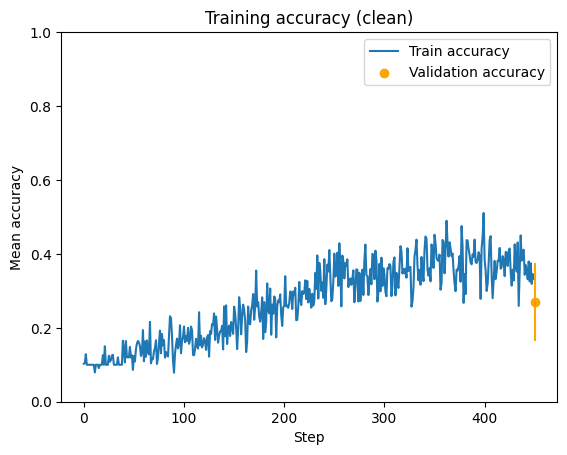

In [ ]:
display_pipeline_results(train_results)

In [ ]:
compute_accuracy(model)

Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

0.37599998712539673

#### Poisoning (no defense)

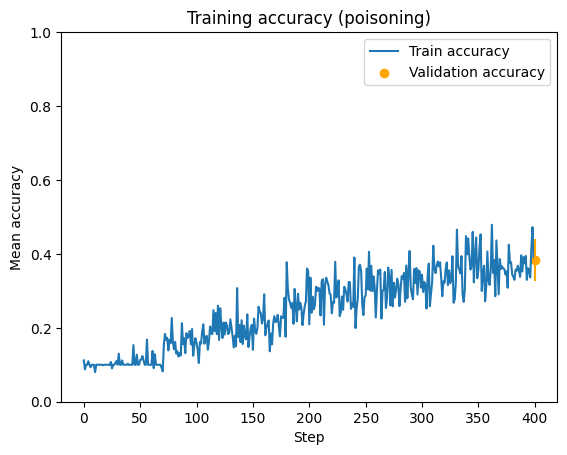

In [ ]:
display_pipeline_results(poison_no_defense_results)

In [ ]:
compute_accuracy(poisoned_no_defense)

Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

0.38989996910095215

#### Poisoning + robust aggregation

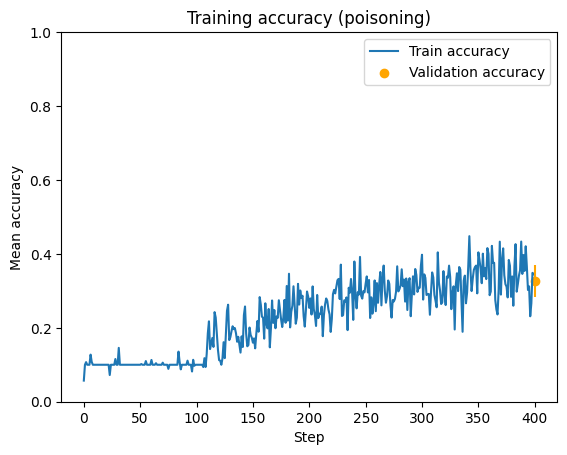

In [ ]:
display_pipeline_results(poison_results)

In [ ]:
compute_accuracy(poisoned)

Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

0.32669997215270996

#### Poisoning + unlearning

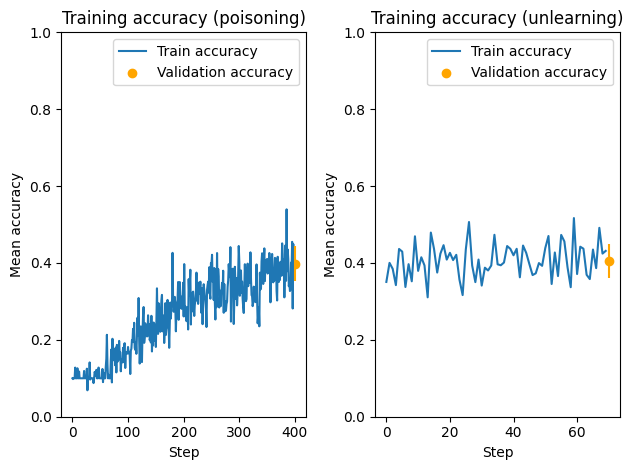

In [ ]:
display_pipeline_results(poison_unlearn_results)

In [ ]:
compute_accuracy(unlearner)

Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

0.4084000289440155

TODO: comment on the results, are they expected?

## Testing gradient estimation with auxiliary dataset

We test the estimation quality of the average clean gradient.

In [ ]:
def eval_gradient_estimation(
        model: nn.Module,
        train: bool = True,
        momentum: float = 0.9,
    ) -> list[float]:
    model = deepcopy(model)
    model.train(train)
    estimator = ShadowGradientEstimator(aux_loader, momentum=momentum)
    omniscient = OmniscientGradientEstimator()

    mini_train_set = random_split(training_data, [0.4, 0.6])[0]
    mini_train_loader = DataLoader(mini_train_set, batch_size=batch_size)
    optimizer = Adam(model.parameters())

    scores = []
    for X, y in mini_train_loader:
        X, y = X.to(BEST_DEVICE), y.to(BEST_DEVICE)
        criterion(model(X), y).backward()
        g_true = omniscient.average_clean_gradient(model, criterion)
        if train:
            optimizer.step()
        optimizer.zero_grad()

        g_pred = estimator.average_clean_gradient(model, criterion)

        cos_sim = torch.cosine_similarity(g_true, g_pred, dim=0).item()
        scores.append(cos_sim)
    return scores

def show_scores(scores: list[float], ax: plt.Axes):
    ax.plot(scores)
    ax.hlines(np.mean(scores), 0, len(scores), color='orange')
    ax.set_xlabel("Step")
    ax.set_ylabel("Cosine similarity")


In [ ]:
def gradient_estimation_comparison(model: nn.Module):
    fig, axes = plt.subplots(1, 5, sharey=True)
    fig.set_figwidth(12)

    momentum = 0.9
    scores_1 = eval_gradient_estimation(model, train=False, momentum=momentum)
    show_scores(scores_1, ax=axes[0])
    axes[0].set_title(f"No training\nmomentum: {momentum}")

    scores_2 = eval_gradient_estimation(model, momentum=momentum)
    show_scores(scores_2, ax=axes[1])
    axes[1].set_title(f"Training\nmomentum: {momentum}")

    momentum = 0.7
    scores_3 = eval_gradient_estimation(model, train=False, momentum=momentum)
    show_scores(scores_3, ax=axes[2])
    axes[2].set_title(f"No training\nmomentum: {momentum}")

    scores_4 = eval_gradient_estimation(model, momentum=momentum)
    show_scores(scores_4, ax=axes[3])
    axes[3].set_title(f"Training\nmomentum: {momentum}")

    scores_5 = eval_gradient_estimation(model, momentum=0.0)
    show_scores(scores_5, ax=axes[4])
    axes[4].set_title(f"Training\nno momentum")

    fig.suptitle("True batch gradient vs. estimated average gradient")
    fig.tight_layout()

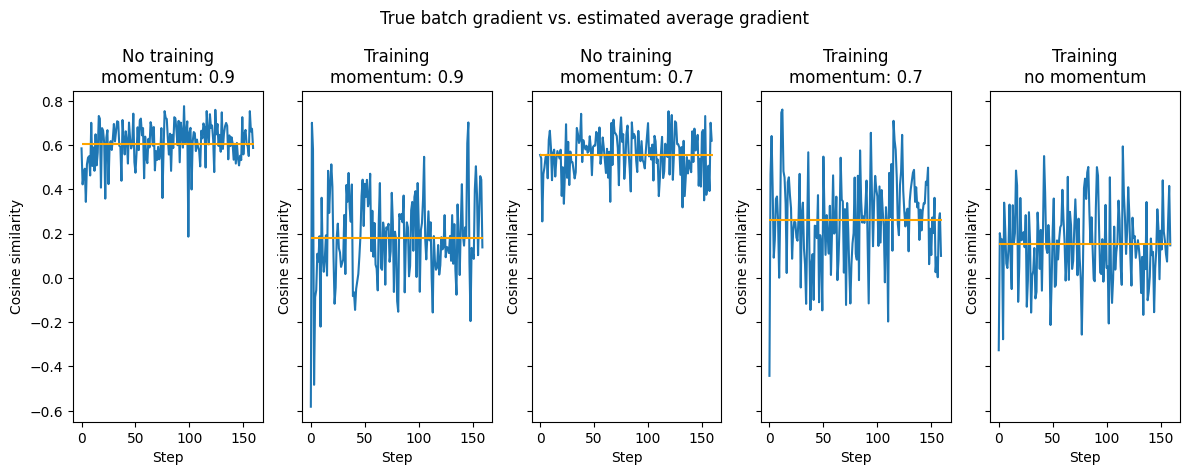

In [ ]:
gradient_estimation_comparison(model)